In [2]:
'''
Notebook to specifically study correlations between ELG targets and Galactic foregrounds

Much of this made possible and copied from script shared by Anand Raichoor
'''

import fitsio
import numpy as np
#from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
from matplotlib import pyplot as plt


In [3]:
#Some information is in pixelized map
#get nside and nest from header
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(fits.open(pixfn)[1].columns.names)
hpq = fitsio.read(pixfn)

['HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY']


In [59]:
#get MC efficiency
mcf = fitsio.read(os.getenv('SCRATCH')+'/ELGMCeffHSCHP.fits')
mmc = np.mean(mcf['EFF'])
mcl = np.zeros(12*nside*nside)
for i in range(0,len(mcf)):
    pix = mcf['HPXPIXEL'][i]
    mcl[pix] = mcf['EFF'][i]/mmc

In [4]:
#ELGs were saved here
elgf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'

In [5]:
#for healpix
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [6]:
#read in ELGs, put them into healpix
felg = fitsio.read(elgf)
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = hp.ang2pix(nside,dth,dphi,nest)

In [7]:
lelg = len(felg)
print(lelg)

47256516


In [8]:
#full random file is available, easy to read some limited number; take 1.5x ELG to start with
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(int(1.5*lelg))
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [9]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

67762950
64567641


In [10]:
#write out randoms
#fitsio.write(os.getenv('SCRATCH')+'/ELGrandoms.fits',relg,overwrite=True)

In [11]:
#put randoms into healpix
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = hp.ang2pix(nside,rth,rphi,nest=nest)

In [12]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
#one function to do directly, the other just for the indices
def splitcat(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

def splitcat_ind(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2

In [13]:
#indices for split
dbml,ddnl,ddsl = splitcat_ind(felg)
rbml,rdnl,rdsl = splitcat_ind(relg)

In [14]:
#put into full sky maps (probably not necessary but easier to keep straight down the line)
pixlrbm = np.zeros(12*nside*nside)
pixlgbm = np.zeros(12*nside*nside)
pixlrdn = np.zeros(12*nside*nside)
pixlgdn = np.zeros(12*nside*nside)
pixlrds = np.zeros(12*nside*nside)
pixlgds = np.zeros(12*nside*nside)

for pix in rpix[rbml]:
    pixlrbm[pix] += 1.
print('randoms done')
for pix in dpix[dbml]:
    pixlgbm[pix] += 1.

for pix in rpix[rdnl]:
    pixlrdn[pix] += 1.
print('randoms done')
for pix in dpix[ddnl]:
    pixlgdn[pix] += 1.
    
for pix in rpix[rdsl]:
    pixlrds[pix] += 1.
print('randoms done')
for pix in dpix[ddsl]:
    pixlgds[pix] += 1.
    


randoms done
randoms done
randoms done


In [50]:
slp = -0.35/4000.
b = 1.1
ws = 1./(slp*hpq['STARDENS']+b)

In [32]:
print(len(pixlgds))

786432


In [55]:
def plotvshp(r1,d1,sys,rng,gdzm=20,ebvm=0.15,useMCeff=True,correctstar=False):
    w = hpq['GALDEPTH_Z'] > gdzm
    w &= hpq['EBV'] < ebvm
    if useMCeff:
        w &= mcl > 0
    if sys != 'gdc' and sys != 'rdc' and sys != 'zdc':
        sm = hpq[w][sys]
    else:
        if sys == 'gdc':
            print('g depth, extinction corrected')
            sm = hpq[w]['GALDEPTH_G']*np.exp(-3.214*hpq[w]['EBV'])
        if sys == 'rdc':
            sm = hpq[w]['GALDEPTH_R']*np.exp(-2.165*hpq[w]['EBV'])
        if sys == 'zdc':
            sm = hpq[w]['GALDEPTH_Z']*np.exp(-1.211*hpq[w]['EBV'])
    ds = np.ones(len(d1))
    if correctstar:
        ds = ws
    dmc = np.ones(len(d1))
    if useMCeff:
        dmc = mcl
    hd1 = np.histogram(sm,weights=d1[w]*ds[w]/dmc[w],range=rng)
    hdnoc = np.histogram(sm,weights=d1[w],bins=hd1[1],range=rng)
    #print(hd1)
    hr1 = np.histogram(sm,weights=r1[w],bins=hd1[1],range=rng)
    #print(hr1)
    xl = []
    for i in range(0,len(hd1[0])):
        xl.append((hd1[1][i]+hd1[1][i+1])/2.)
    plt.errorbar(xl,hd1[0]/hr1[0]/(lelg/len(relg)),np.sqrt(hd1[0])/hr1[0]/(lelg/len(relg)),fmt='ko')
    if useMCeff:
        plt.plot(xl,hdnoc[0]/hr1[0]/(lelg/len(relg)),'k--')
    print(hd1[0]/hr1[0]/(lelg/len(relg)))
    #plt.title(str(mp)+reg)
    plt.ylabel('relative density')
    plt.xlabel(sys)
    plt.ylim(0.7,1.3)
    plt.show()    

[ 0.9864467   0.98490527  0.99086769  0.98270395  0.96349208  0.95412323
  0.98790553  0.98459179  0.95032714  0.9494714 ]


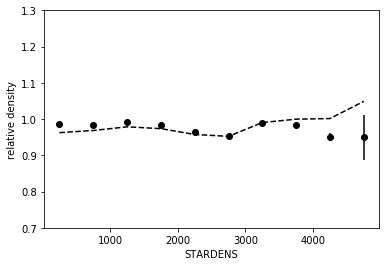

[ 0.96198538  0.98188718  0.98782877  0.97503877  0.97793315  0.97793663
  0.99615232  1.00678955  1.04582761  1.07541003]


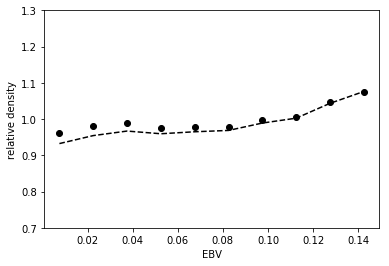

g depth, extinction corrected
[ 1.04605073  1.0308887   0.99553055  0.99754715  0.98420782  0.95637931
  0.96467528  0.97775882  0.99598656  0.98868995]


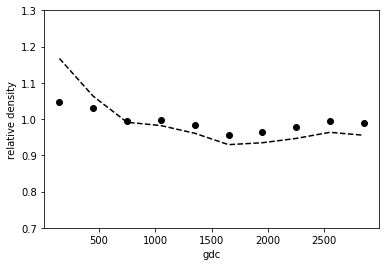

[ 1.10289948  1.04554984  1.0084604   0.99709483  0.99913718  1.00876887
  0.97484036  0.94949045  0.9589209   0.94954909]


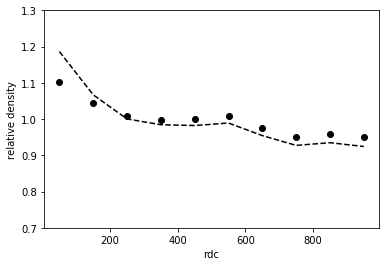

[ 1.02096342  0.99781856  0.99256746  0.9944486   0.98832801  0.9710489
  0.9623823   0.95750839  0.93731372  0.91922712]


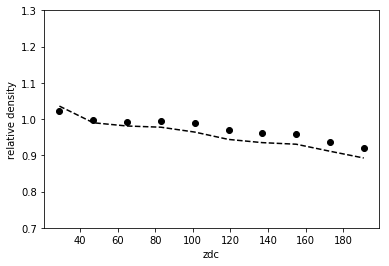

In [60]:
plotvshp(pixlrds,pixlgds,'STARDENS',(0,0.5e4))
plotvshp(pixlrds,pixlgds,'EBV',(0,0.15))
plotvshp(pixlrds,pixlgds,'gdc',(0,3000))
plotvshp(pixlrds,pixlgds,'rdc',(0,1000))
plotvshp(pixlrds,pixlgds,'zdc',(20,200))

[ 1.06975474  1.04147674  0.98268887  0.94777531  0.89757808  0.86489995
  0.82454931  0.78140141  0.71842452  0.72275162]


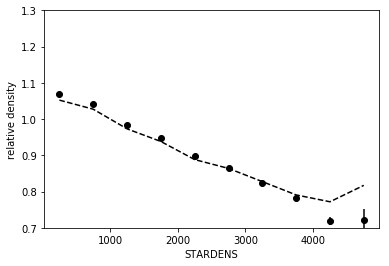

[ 1.03785127  1.05637877  1.04638449  1.00431008  0.94276517  0.9130858
  0.87604079  0.8655834   0.87812055  0.8937069 ]


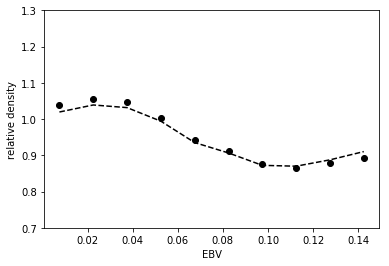

g depth, extinction corrected
[ 0.92576647  1.03876405  1.03447845  1.02486765  0.99779655  0.97154534
  0.9730369   1.03696744         nan         nan]


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


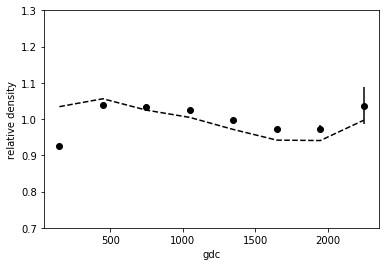

[ 1.03287707  1.06634892  1.05010289  1.02268504  0.98290746  0.93341956
  0.93475254  0.9372061   0.90614041  0.83626489]


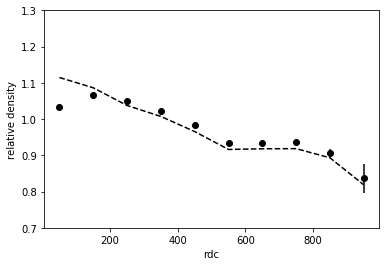

[ 0.99942457  1.03813232  1.02130705  1.01973684  1.01766766  0.99352707
  0.99230402  1.05545198  1.05972311  1.02232018]


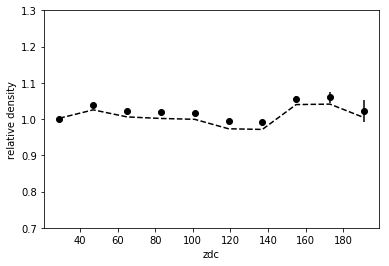

In [61]:
plotvshp(pixlrdn,pixlgdn,'STARDENS',(0,0.5e4))
plotvshp(pixlrdn,pixlgdn,'EBV',(0,0.15))
plotvshp(pixlrdn,pixlgdn,'gdc',(0,3000))
plotvshp(pixlrdn,pixlgdn,'rdc',(0,1000))
plotvshp(pixlrdn,pixlgdn,'zdc',(20,200))

[ 1.06346867  1.00365651  0.94684795  0.93924167  0.91702765  0.89756997
  0.8627816   0.84735919  0.80984106  0.84607471]


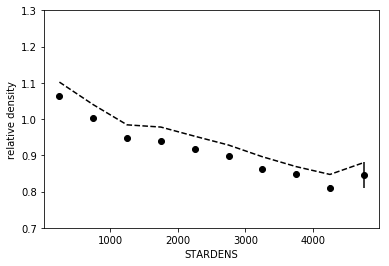

[ 1.05398276  1.04572511  0.97988274  0.94687172  0.89032675  0.85615271
  0.83975847  0.81075091  0.80383507  0.79697432]


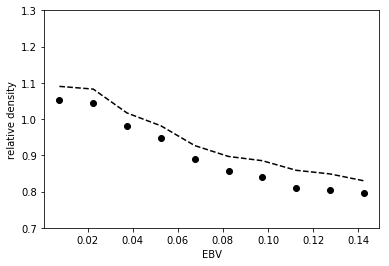

g depth, extinction corrected
[ 1.03707434  0.99668665  1.00470322  0.99952604  1.0100305   1.01649473
  1.07134218  1.37142395  0.8247678          nan]


/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/global/common/software/desi/cori/desiconda/20180709-1.2.6-spec/conda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in true_divide


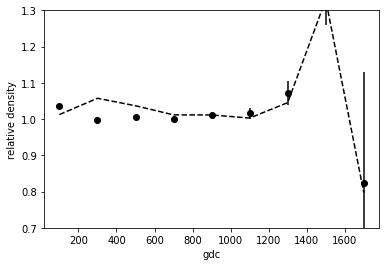

[ 1.00739782  1.00514035  0.97477435  0.91756048  0.87189425  1.35951191
  1.57618047         nan         nan         nan]


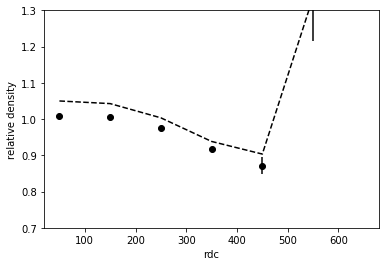

[ 0.94460282  0.99112432  1.01288477  1.01920495  1.00021107  1.01484447
  1.0350452   1.16144316  1.12721128         nan]


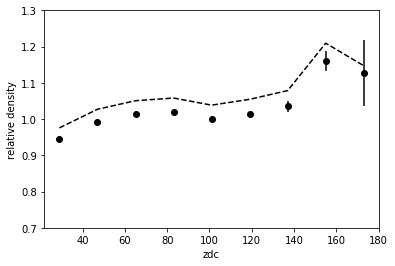

In [62]:
plotvshp(pixlrbm,pixlgbm,'STARDENS',(0,0.5e4))
plotvshp(pixlrbm,pixlgbm,'EBV',(0,0.15))
plotvshp(pixlrbm,pixlgbm,'gdc',(0,2000))
plotvshp(pixlrbm,pixlgbm,'rdc',(0,1000))
plotvshp(pixlrbm,pixlgbm,'zdc',(20,200))

In [20]:
hg1 = np.histogram(felg[dbml]['GALDEPTH_G']*np.exp(-3.214*felg[dbml]['EBV']),range=(0,2000))
hr1 = np.histogram(relg[rbml]['GALDEPTH_G']*np.exp(-3.214*relg[rbml]['EBV']),bins=hg1[1])

In [21]:
hg2 = np.histogram(felg[ddnl]['GALDEPTH_G']*np.exp(-3.214*felg[ddnl]['EBV']),range=(0,3000))
hr2 = np.histogram(relg[rdnl]['GALDEPTH_G']*np.exp(-3.214*relg[rdnl]['EBV']),bins=hg2[1])
hg3 = np.histogram(felg[ddsl]['GALDEPTH_G']*np.exp(-3.214*felg[ddsl]['EBV']),range=(0,2000))
hr3 = np.histogram(relg[rdsl]['GALDEPTH_G']*np.exp(-3.214*relg[rdsl]['EBV']),bins=hg3[1])

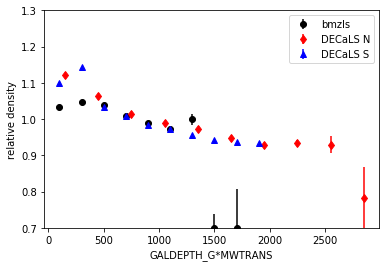

In [22]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
plt.errorbar(xl1,hg1[0]/hr1[0]/(lelg/len(relg)),np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]/(lelg/len(relg)),np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.errorbar(xl3,hg3[0]/hr3[0]/(lelg/len(relg)),np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.show()

In [23]:
hg1[0]/hr1[0]/(lelg/len(relg))


array([ 1.03436801,  1.04832597,  1.03778993,  1.00997978,  0.99063835,
        0.97162805,  0.99942371,  0.70028785,  0.69904872,  0.34158062])

In [24]:
gfluxc = felg['FLUX_G']/felg['MW_TRANSMISSION_G']
rfluxc = felg['FLUX_R']/felg['MW_TRANSMISSION_R']
zfluxc = felg['FLUX_Z']/felg['MW_TRANSMISSION_Z']

In [25]:
len(hpq)

786432